In [2]:
%pip install numpy pandas matplotlib scikit-learn statsmodels scipy

Note: you may need to restart the kernel to use updated packages.


In [31]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.regression.quantile_regression import QuantReg
from sklearn.model_selection import train_test_split
from functions import plot_quantile_regression, quantile_loss, wald_test, score_test, lm_test, compare_quantile_coeffs

# Random On-time delivery dataset

In [32]:
np.random.seed(42)
N = 100

**Features**

In [33]:
distance_to_customer = np.random.uniform(1, 50, size=N)  #  km
order_prep_time = np.random.uniform(5, 60, size=N)  #  time in minutes
traffic_level = np.random.uniform(1, 10, size=N)  # Traffic congestion level (1=low, 10=high)
delivery_time = (
    30 + 0.8 * distance_to_customer + 0.5 * order_prep_time + 3 * traffic_level + np.random.normal(scale=10, size=N)
) # Delivery time calculation with some noise

**Create a DataFrame**

In [46]:
data = pd.DataFrame({
    'distance_to_customer': distance_to_customer,
    'order_prep_time': order_prep_time,
    'traffic_level': traffic_level,
    'delivery_time': delivery_time
})
data.head()

,distance_to_customer,order_prep_time,traffic_level,delivery_time
0,19.352466,6.728605,6.778285,69.636848
1,47.585001,40.002573,1.757260,86.825063
2,36.867703,22.289579,2.454658,99.442368
3,30.334266,32.971388,9.086988,104.353260
4,8.644913,54.916156,6.457862,63.496167


**Split the data into training and testing sets**

In [35]:
train, test = train_test_split(data, test_size=0.2, random_state=42)

In [36]:
X_train = sm.add_constant(train[['distance_to_customer', 'order_prep_time', 'traffic_level']].values)
y_train = train['delivery_time'].values

X_test = sm.add_constant(test[['distance_to_customer', 'order_prep_time', 'traffic_level']].values)
y_test = test['delivery_time'].values

**Quantiles for quantile regression**

In [37]:
taux1 = 0.25
taux2 = 0.5
taux3 = 0.75

**Fit Quantile Regression Models**

In [38]:
model = QuantReg(y_train, X_train)
result_25 = model.fit(q=taux1)
result_50 = model.fit(q=taux2)
result_75 = model.fit(q=taux3)

In [39]:
print("Quantile regression results (taux = 0.25): ", result_25.summary())
print("\nQuantile regression results (taux = 0.5): ", result_50.summary())
print("\nQuantile regression results (taux = 0.75): ", result_75.summary())

Quantile regression results (taux = 0.25):                           QuantReg Regression Results                          
Dep. Variable:                      y   Pseudo R-squared:               0.5549
Model:                       QuantReg   Bandwidth:                       8.217
Method:                 Least Squares   Sparsity:                        26.33
Date:                Fri, 20 Dec 2024   No. Observations:                   80
Time:                        19:45:21   Df Residuals:                       76
                                        Df Model:                            3
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         20.6248      5.766      3.577      0.001       9.141      32.109
x1             0.7946      0.097      8.231      0.000       0.602       0.987
x2             0.5385      0.080      6.697      0.000       0.378       0.699
x3      

**Call the plotting function**

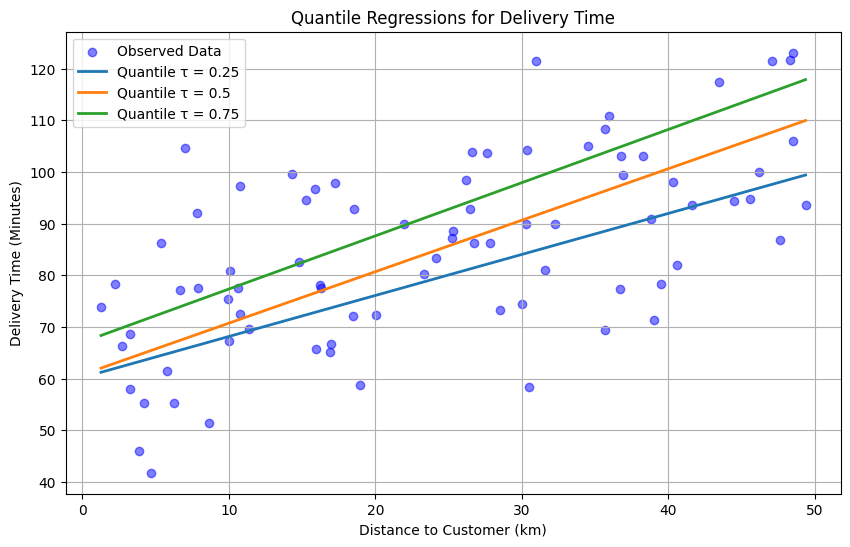

In [40]:
plot_quantile_regression(X_train, y_train, [result_25, result_50, result_75], [taux1, taux2, taux3])

**Predict on test data and compute quantile loss**

In [41]:
y_pred_25 = result_25.predict(X_test)
y_pred_50 = result_50.predict(X_test)
y_pred_75 = result_75.predict(X_test)

loss_25 = quantile_loss(y_test, y_pred_25, taux1)
loss_50 = quantile_loss(y_test, y_pred_50, taux2)
loss_75 = quantile_loss(y_test, y_pred_75, taux3)

print("\nQuantile Loss on Test Data:")
print(f"  τ = {taux1}: Loss = {loss_25:.3f}")
print(f"  τ = {taux2}: Loss = {loss_50:.3f}")
print(f"  τ = {taux3}: Loss = {loss_75:.3f}")


Quantile Loss on Test Data:
  τ = 0.25: Loss = 5.335
  τ = 0.5: Loss = 5.515
  τ = 0.75: Loss = 4.104


**Apply Wald Test for median quantile regression (τ = 0.5)**

In [42]:
wald_test(result_50)


Wald Test Results:
  Coefficient: 0.997
  Wald Statistic: 10.566
  P-value: 0.000


**Apply Score Test for median quantile regression (τ = 0.5)**

In [43]:
score_test(result_50, X_train, y_train, taux2)


Score Test Results:
  Score Statistic: -0.001
  P-value: 0.999


**Apply LM Test for median quantile regression (τ = 0.5)**

In [44]:
lm_test(result_50, X_train, y_train)


Lagrange Multiplier (LM) Test Results:
  LM Statistic: -2.475
  P-value: 1.000


**Compare coefficients between τ = 0.25 and τ = 0.75**

In [45]:
compare_quantile_coeffs(X_train, y_train, taux1, taux3)


Comparison of Coefficients between τ = 0.25 and τ = 0.75:
  Difference of Coefficients: -0.236
  T-statistic: -1.615
  P-value: 0.106
